In [78]:
import jax
#import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad, jacobian

### 2 times IWP

In [79]:
A = lambda h: np.array([[1, h, h**2/2], [0, 1, h], [0, 0, 1]])
Q = lambda h: np.array([[h**5/20, h**4/8, h**3/6], [h**4/8, h**3/3, h**2/2], [h**3/6, h**2/2, h]])

In [80]:
#function that samples q-times IWP path
def sample_IWP_path(q, N, h, y0=None):

    mu_0 = np.zeros(q)
    Sigma_0 = np.eye(q)
    if y0 != None:
        mu_0[0] = y0
        Sigma_0[0,0] = 0
    x = np.zeros((N, q))
    x_0 = np.random.multivariate_normal(mu_0, Sigma_0)
    x[0,:] = x_0

    for i in range(1, N):
        x[i,:] = np.random.multivariate_normal(A(h)@x[i-1,:], Q(h))
    return x



#function that samples q-times IWP path
def sample_IWP_path_from_taylor_modes(q, N, h, x_0):

    x = np.zeros((N, q))
    x[0,:] = x_0

    for i in range(1, N):
        x[i,:] = np.random.multivariate_normal(A(h)@x[i-1,:], Q(h))
    return x


In [81]:
np.random.seed(42)

t0, t1 = 0.0, 10.0
N = 222
ts = np.linspace(t0, t1, num=N, endpoint=True)
h = (t1 - t0) / N

#x1 = sample_IWP_path(3, N, h)
#x2 = sample_IWP_path(3, N, h)
#x3 = sample_IWP_path(3, N, h)
#x4 = sample_IWP_path(3, N, h)
#x5 = sample_IWP_path(3, N, h)

x1 = sample_IWP_path(3, N, h, y0=-3)
x2 = sample_IWP_path(3, N, h, y0=-3)
x3 = sample_IWP_path(3, N, h, y0=-3)
x4 = sample_IWP_path(3, N, h, y0=-3)
x5 = sample_IWP_path(3, N, h, y0=-3)

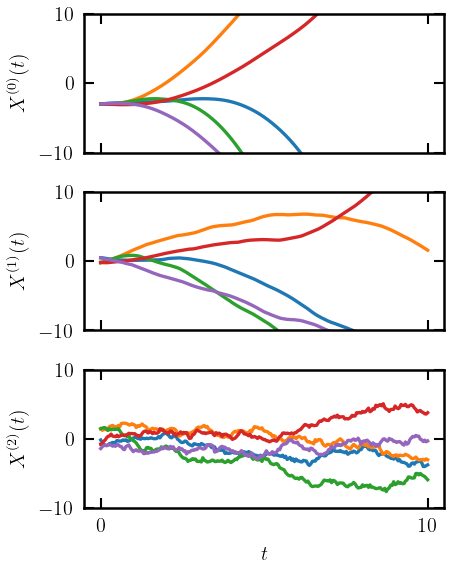

In [82]:
# Create a 3x1 subplot for each component of x
fig, axs = plt.subplots(3, 1, figsize=(4, 5))

# Plot each component of x
for i in range(3):
    axs[i].plot(ts, x1[:, i])
    axs[i].plot(ts, x2[:, i])
    axs[i].plot(ts, x3[:, i])
    axs[i].plot(ts, x4[:, i])
    axs[i].plot(ts, x5[:, i])
    if i == 2:
        axs[i].set_xlabel('$t$')
        axs[i].set_xticks([0, 10])
    if i < 2:
        axs[i].set_xticks([0, 10])
        axs[i].set_xticklabels([])
    axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
    axs[i].set_ylim(-10, 10)
    axs[i].set_yticks([-10, 0, 10])

plt.savefig('2-times-IWP.png')
    

### Exp 1: Logistic ODE


$$ \dot{x} = x * (1 - x), \quad x_0 = 0.01$$

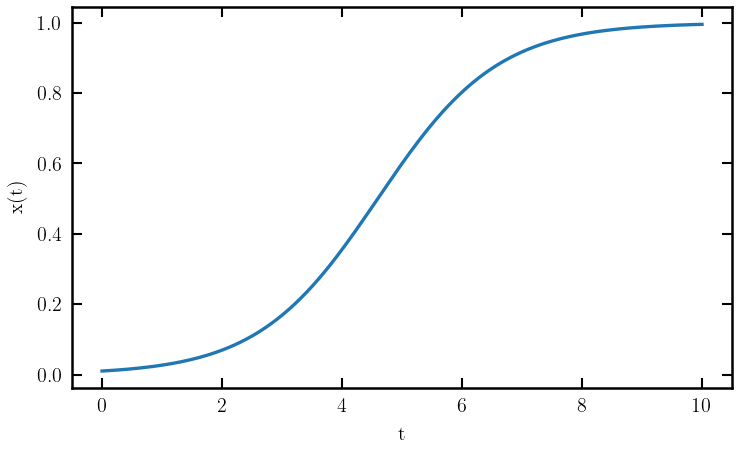

In [83]:
vf = lambda x: x*(1-x)
#exact solution:
x_exact = lambda t: 1 / (1 + (1 / 0.01 - 1) * np.exp(-t))

t = np.linspace(0, 10, 200)
plt.plot(t, x_exact(t), label='Exact Solution')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.show()

In [84]:
y0 = 0.01
# initialize X(0) via the taylor coefficients
X_0 = np.array([y0, vf(y0), (1-y0)*(1-2*y0)*y0])

In [85]:
print(X_0[2]) 
print("this was manually computed, however in reality these taylor modes can be computed efficiently via autodiff:")
#autodiff of vf
vf_autodiff = jax.grad(vf)
print(vf(y0) * vf_autodiff(y0))


0.009702
this was manually computed, however in reality these taylor modes can be computed efficiently via autodiff:
0.009702


#### 1.1 Prior with correct Initialization

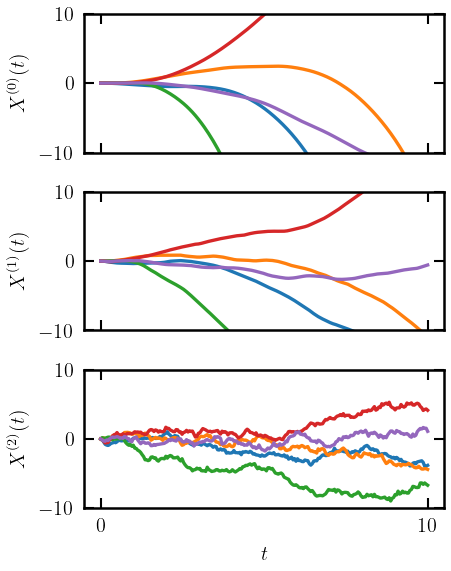

In [86]:
np.random.seed(42)

t0, t1 = 0.0, 10.0
N = 222
ts = np.linspace(t0, t1, num=N, endpoint=True)
h = (t1 - t0) / N

x1 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x2 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x3 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x4 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x5 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)

# Create a 3x1 subplot for each component of x
fig, axs = plt.subplots(3, 1, figsize=(4, 5))

# Plot each component of x
for i in range(3):
    axs[i].plot(ts, x1[:, i])
    axs[i].plot(ts, x2[:, i])
    axs[i].plot(ts, x3[:, i])
    axs[i].plot(ts, x4[:, i])
    axs[i].plot(ts, x5[:, i])
    if i == 2:
        axs[i].set_xlabel('$t$')
        axs[i].set_xticks([0, 10])
    if i < 2:
        axs[i].set_xticks([0, 10])
        axs[i].set_xticklabels([])
    axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
    axs[i].set_ylim(-10, 10)
    axs[i].set_yticks([-10, 0, 10])

#plt.savefig('2-times-IWP.png')

#### 1.2 Measurement Model

In [104]:
E_0 = np.array([[1,0,0]])
E_1 = np.array([[0,1,0]])
R = np.array([[0.22]])

g = lambda X: X[1] - vf(X[0])

jacobian_g = jacobian(g)

#### 1.3 Define Observed data

In [105]:
z_sequence = np.zeros(N).reshape(-1,1)

In [162]:
def filter_light_affine(m_t_minus, P_t_minus, A, Q, H, c, R, y):
    m_t_minus = A @ m_t_minus
    P_t_minus = A @ P_t_minus @ A.T + Q
    z = y - H @ m_t_minus - c
    S = H @ P_t_minus @ H.T + R
    K = P_t_minus @ H.T @ np.linalg.inv(S)
    m_t = m_t_minus + K @ z 
    P_t = (np.eye(len(K)) - K @ H) @ P_t_minus
    return m_t, P_t

def future_prediction(m_t_minus, P_t_minus, A, Q):
    m_t_minus = A @ m_t_minus
    P_t_minus = A @ P_t_minus @ A.T + Q
    return m_t_minus, P_t_minus


def extended_kalman_filter(t, mu_0, Sigma_0, A_h, Q_h, R, z_sequence):

    m_sequence = [mu_0]
    P_sequence = [Sigma_0] 

    for t in range(t):
        linearization_point = m_sequence[-1]
        H = jacobian_g(linearization_point).reshape(1,-1)
        c = g(linearization_point) - H @ linearization_point


        m_prime, P_prime = filter_light_affine(m_sequence[-1], P_sequence[-1], A_h, Q_h, H, c, R, z_sequence[t])
        m_sequence.append(m_prime)
        P_sequence.append(P_prime)

    m_future = [m_sequence[-1]]
    P_future = [P_sequence[-1]]
        
    if t == 0:
        for t in range(t, 100):
            m_next, P_next = future_prediction(m_future[-1], P_future[-1], A_h, Q_h)
            m_future.append(m_next)
            P_future.append(P_next)
    else:
        for t in range(t+1, 100):
            m_next, P_next = future_prediction(m_future[-1], P_future[-1], A_h, Q_h)
            m_future.append(m_next)
            P_future.append(P_next)

    m_projected = np.array(m_sequence)[:,0]
    P_projected = np.array(P_sequence)[:,0,0]
    m_projected = m_projected.squeeze()
    P_projected = P_projected.squeeze()

    m_future_projected = np.array(m_future)[:,0]
    P_future_projected = np.array(P_future)[:,0,0]
    m_future_projected = m_future_projected.squeeze()
    P_future_projected = P_future_projected.squeeze()

    return m_projected, P_projected, m_future_projected, P_future_projected

In [163]:
print(h)
m_0 = X_0
Sigma_0 = np.eye(3)*0

A_h = A(h)
Q_h = Q(h)

print(m_0.shape, Sigma_0.shape)
print(A_h.shape, Q_h.shape)


0.04504504504504504
(3,) (3, 3)
(3, 3) (3, 3)


In [169]:
t = 221
m_projected, P_projected, m_future_projected, P_future_projected = extended_kalman_filter(t, m_0, Sigma_0, A_h, Q_h, R, z_sequence)

ValueError: x and y must have same first dimension, but have shapes (222,) and (1,)

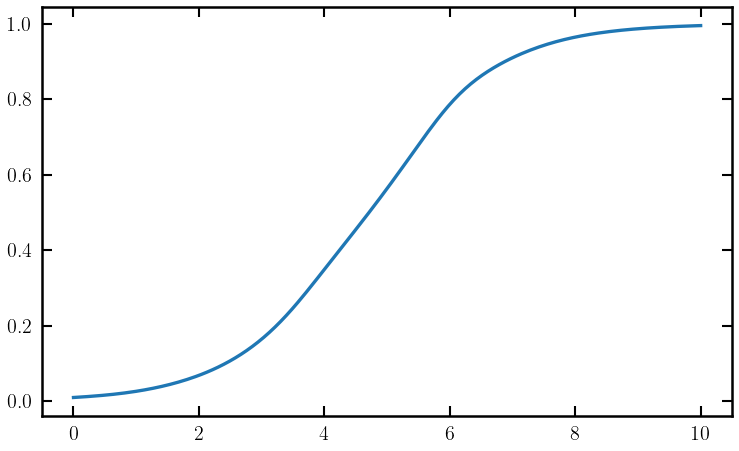

In [170]:
#plot the results
plt.plot(ts, m_projected)
plt.plot(ts, m_future_projected)
plt.show()




In [126]:
t = 0
linearization_point = m_sequence[-1]
H = jacobian_g(linearization_point).reshape(1,-1)
c = g(linearization_point) - H @ linearization_point

m_prime, P_prime = filter_light_affine(m_sequence[-1], P_sequence[-1], A_h, Q_h, H, c, R, z_sequence[t])


m_sequence.append(m_prime)
P_sequence.append(P_prime)

In [ ]:





m_sequence.append(m_prime)
P_sequence.append(P_prime)

m_future = [m_sequence[-1]]
P_future = [P_sequence[-1]]

IndexError: arrays used as indices must be of integer (or boolean) type